## Исследование данных о российском кинопрокате <a id="main_title"></a>

### Описание проекта <a id="description_project"></a>

Описание проекта  
Заказчик этого исследования — `Министерство культуры Российской Федерации`.  
Вам нужно изучить рынок российского кинопроката и выявить текущие тренды. Уделите внимание фильмам, которые получили государственную поддержку. Попробуйте ответить на вопрос, насколько такие фильмы интересны зрителю.  
Набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск.

Основные цели проекта:
- Статистика по годам: сколько ежегодно выходит фильмов?
- Найти изменения выручки по годам
- Определить, влияет ли возрастные ограничения на сборы. Меняется ли картинка с годами?
- Исследовать фильмы с гос.поддержкой(окупаемость и рейтинг)

### Шаг 1. Откройте файлы с данными и объедините их в один датафрейм. 

Объедините данные таким образом, чтобы все объекты из датасета `mkrf_movies` обязательно вошли в получившийся датафрейм. 

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_0" aria-expanded="false" aria-controls="collapseHint_0">Подсказка</button>
        </div>
        <div id="collapseHint_0" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Обратите внимание на тип данных столбца, по которому будете соединять датафреймы. Тип данных этих столбцов должен быть одинаковым в обоих датафреймах.
            </div>
        </div>
    </div>
</div>

### Открываем данные, описание столбцов <a id="open_data"></a>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
df = pd.read_csv('mkrf_movies.csv', parse_dates=['show_start_date'])
df2 = pd.read_csv('mkrf_shows.csv')
matplotlib.style.use('seaborn-pastel') 

Описание столбцов:
- `title` — название фильма;
- `puNumber` — номер прокатного удостоверения;
- `show_start_date` — дата премьеры фильма;
- `type` — тип фильма;
- `film_studio` — студия-производитель;
- `production_country` — страна-производитель;
- `director` — режиссёр;
- `producer` — продюсер;
- `age_restriction` — возрастная категория;
- `refundable_support` — объём возвратных средств государственной поддержки;
- `nonrefundable_support` — объём невозвратных средств государственной поддержки;
- `financing_source` — источник государственного финансирования;
- `budget` — общий бюджет фильма;
- `ratings` — рейтинг фильма на КиноПоиске;
- `genres` — жанр фильма.
- `box_office` — сборы в рублях. (из второй базы)


[Вернуться к содержанию](#main_title)

### Объединение файлов

In [2]:
print(len(df[df['puNumber'].duplicated()]))
print(len(df2[df2['puNumber'].duplicated()]))

2
0


In [3]:
# дубликаты по номерам прокатных удостоверений есть, но всего парочка... кикаем
df.drop_duplicates(subset='puNumber', inplace=True)

In [4]:
# При первой попытке объединить выдал ошибку, разные типы, при попытке перевести в int, выдал оишбку на "нет":
df = df.query('puNumber != "нет"')
df['puNumber'] = df['puNumber'].astype(int)
df = df.merge(df2, on='puNumber', how='outer')

In [5]:
del df2 # Удаляем, чтоб глаза не мазолила в пространстве имен

### Шаг 2. Предобработка данных

#### Шаг 2.1. Проверьте типы данных

- Проверьте типы данных в датафрейме и преобразуйте их там, где это необходимо.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7483 entries, 0 to 7482
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   title                  7483 non-null   object             
 1   puNumber               7483 non-null   int32              
 2   show_start_date        7483 non-null   datetime64[ns, UTC]
 3   type                   7483 non-null   object             
 4   film_studio            7465 non-null   object             
 5   production_country     7481 non-null   object             
 6   director               7474 non-null   object             
 7   producer               6915 non-null   object             
 8   age_restriction        7483 non-null   object             
 9   refundable_support     332 non-null    float64            
 10  nonrefundable_support  332 non-null    float64            
 11  budget                 332 non-null    float64          

#### Шаг 2.2. Изучите пропуски в датафрейме

- Объясните, почему заполнили пропуски определённым образом или почему не стали этого делать.

|Название столбца |Название фильма |Что будем с делать с пропусками|
|-----------------------|----------|--------------------------------------|
|`film_studio`|студия-производитель|в исследовании не участвует(оставим NaN)|
|`production_country`| страна-производитель | всего пару пропусков - удалим значения|
|`director`| режиссёр | в исследовании не участвует(можно удалить, но зачем то просят выделить фамилию)|
|`producer`| продюсер | в исследовании не участвует(можно удалить)|
|`refundable_support`| объём возвратных средств гос.поддержки | пропуски заполним нулями*|
|`nonrefundable_support`| объём невозвратных средств гос.поддержки | пропуски заполним нулями|
|`budget`| общий бюджет фильма | сначало не будем трогать, как до момента бюджета доберемся, уберем все строки с NaN значениями|
|`financing_source`|источник государственного финансирования| поставим значение "Без госсподержки"|
|`ratings`| рейтинг фильма на КиноПоиске | Значение важное и с бухты-барахты поставить нельзя. удаляем довольно большое кол-во строк|
|`genres`| жанр фильма | Оставим пропуски данных|
|`box_office`| box_office| | Заменим выборки на нули|

*Столбцы связанные с гос.бюджетом NaN заполним нулями, т.к. скорее всего это связано с тем что поддержки не было или фильм забугорный и данных об этом нет, в исследовании по гос.поддержки, забугорные фильмы выкинем все равно и будем смотреть только российские

In [7]:
df.dropna(subset=['production_country'], inplace=True)
df.dropna(subset=['ratings'], inplace=True)
df['refundable_support'].fillna(0, inplace=True)
df['nonrefundable_support'].fillna(0, inplace=True)
df['financing_source'].fillna('Без госсподдержки', inplace=True)
df['box_office'].fillna(0, inplace=True)

#### Шаг 2.3. Изучите дубликаты в датафрейме
- Проверьте, есть ли в данных дубликаты. Опишите причины, которые могли повлиять на появление дублей.

In [8]:
df_duplicated = df[df['title'].duplicated(keep=False)]

In [9]:
print(len(df[df['title'].duplicated() & df['director'].duplicated()]))
print(len(df[df['title'].duplicated()]))
print(len(df[df['title'].duplicated() &  ~ df['director'].duplicated()]))
print(len(df[df['puNumber'].duplicated()]))
df_duplicated = df_duplicated[~ df_duplicated['director'].duplicated(keep=False)]

679
704
25
0


Тщательно рассмотрев дубликаты, можно увидеть, что прежде всего они связаны с тем что на один фильм может быть несколько прокатных удостоверений, с одной стороны хочется удалить такие дубли, О т.к. несколько сетей кинотеатров брали эти удостоверния, то как правило это фильм высокобюджетный и кассовый, поэтому удалить такие дубли не будем и по ним можно.  
В связи с этим дубли пока оставим, но аннализируя какие то параметры надо не забывать об этом

In [10]:
del df_duplicated

#### Шаг 2.4. Изучите категориальные значения

- Посмотрите, какая общая проблема встречается почти во всех категориальных столбцах;
- Исправьте проблемные значения в поле `type`.

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_1" aria-expanded="false" aria-controls="collapseHint_1">Подсказка</button>
        </div>
        <div id="collapseHint_1" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
В поле <code>type</code> есть несколько значений, у которых появился пробел в начале строки. Самый простой способ их «починить» -- использовать метод <a href="https://pandas.pydata.org/docs/reference/api/pandas.Series.str.strip.html#pandas.Series.str.strip">.str.strip</a>. Этот метод удаляет все пробелы, которые встречаются в начале и в конце строки. Применяют его таким образом:<br>
<code>df['type'].str.strip()</code>
            </div>
        </div>
    </div>
</div>

In [11]:
df['type'].value_counts()

Художественный                4302
 Художественный               1234
Анимационный                   570
Прочие                         210
Документальный                 162
Научно-популярный               35
 Анимационный                    1
Музыкально-развлекательный       1
Name: type, dtype: int64

In [12]:
df['type'] = df['type'].str.strip()

# Первональный вариант решения(до открытия доступа к сборному проекту)
# change_types = {
#     ' Художественный' : 'Художественный',
#     'Научно-популярный' : 'Прочие',
#     'Музыкально-развлекательный' : 'Прочие',
#     ' Анимационный' : 'Анимационный',
# }
# df['type'] = df['type'].replace(change_types)
# del change_types

In [13]:
df['type'].value_counts()

Художественный                5536
Анимационный                   571
Прочие                         210
Документальный                 162
Научно-популярный               35
Музыкально-развлекательный       1
Name: type, dtype: int64

In [14]:
df['production_country'].value_counts()

США                                                                       2103
Россия                                                                    1296
СССР                                                                       331
Франция                                                                    289
Великобритания                                                             190
                                                                          ... 
Великобритания - США - Австралия - Ирландия - Германия - Куба - Канада       1
Аргентина - Мексика - Бразилия - Франция - США                               1
Швеция - США                                                                 1
Франция - Германия - Турция - Катар                                          1
Дания - Канада - Швеция - Франция - Германия - Великобритания - США          1
Name: production_country, Length: 878, dtype: int64

#### Шаг 2.5. Проверьте количественные значения

- Проверьте, обнаружились ли в таких столбцах подозрительные данные. Как с такими данными лучше поступить?

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_budget" aria-expanded="false" aria-controls="collapseHint_budget">Подсказка</button>
        </div>
        <div id="collapseHint_budget" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Обратите внимание на описание столбца <code>budget</code>. Как этот столбец соотносится с двумя другими: <code>refundable_support</code> и <code>nonrefundable_support</code>?
            </div>
        </div>
    </div>
</div>

Есть фильмы в которых не указан бюджет, но есть финансирование. заполним бюджет медианным значением для фильмов, у которых есть финансирование.
Также переведем стоимости к инту

In [15]:
df['part_of_state_budget'] = (df['nonrefundable_support'] + df['refundable_support']) / df['budget']
df['financing_total'] = df['nonrefundable_support']+df['refundable_support']
mean_budget = df.query('financing_total != 0')['part_of_state_budget'].median()
df['part_of_state_budget'].replace(np.inf, mean_budget, inplace=True)
df['budget'] = df.apply(lambda row: row['budget'] if row['budget'] != 0 else row['financing_total'] / mean_budget, axis=1)
del mean_budget

### Рейтинг фильмов

Была первоначальная идея, что 80% соответствуют рейтингу 8.0, но когда сказка о добре и вре стала первой в рейтинге, понял что что-то тут не то. В итоге принято решение заменить такие рейтинге на Nan
Рейтинги указаны в чем попало, поэтому приводим к единной системе, приниципальной разнице какой: нет, поэтому приводим к баллам от 1.0 до 10.0

In [16]:
# Первоначальная задумка
# df['ratings'] = df['ratings'].str.replace('%', '').astype(float)
# df['ratings'] = df['ratings'].apply(lambda row: row/10 if row > 10 else row)

df['ratings'] = df['ratings'].apply(lambda row: None if '%' in row else row)
df['ratings'] = pd.to_numeric(df['ratings'])

Сделал думаю что 85% соответствуют 8.5 баллам

#### Шаг 2.6. Добавьте новые столбцы





In [17]:
df['is_rus'] = df.apply(lambda row: 1 if 'Россия' in row['production_country'] else 0, axis=1)

- Создайте столбец с информацией о годе проката. Выделите год из даты премьеры фильма.

In [18]:
df['year'] = df['show_start_date'].dt.year
# df.drop(columns=['show_start_date', 'producer'], inplace=True)

- Создайте два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно.

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_2" aria-expanded="false" aria-controls="collapseHint_2">Подсказка</button>
        </div>
        <div id="collapseHint_2" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Чтобы создать такие столбцы, лучше всего использовать собственную функцию. Эту функцию можно применить к двум столбцам сразу. 
            </div>
        </div>
    </div>
</div>

In [19]:
df['genres'].value_counts()

драма                           476
комедия                         352
мелодрама,комедия               222
драма,мелодрама,комедия         189
драма,мелодрама                 183
                               ... 
мюзикл,фэнтези,семейный           1
мюзикл,мелодрама,фэнтези          1
документальный,новости,драма      1
семейный,детектив,детский         1
мелодрама,история,драма           1
Name: genres, Length: 742, dtype: int64

In [20]:
def extraction_genre(row):
    try:
        row = row.split(',')
        return row[0]
    except:
        return None

# Проверка работоспособности функции
print(extraction_genre('мелодрама'))
print(extraction_genre(None))
print(extraction_genre('мелодрама, драма'))

мелодрама
None
мелодрама


In [21]:
df['main_genre'] = df['genres'].apply(extraction_genre)

Переименовываем жанры которые редко встречаются:

In [22]:
df['main_genre'].fillna('неизвестно', inplace=True)
check_genre = df['main_genre'].value_counts()
df['main_genre'] = df['main_genre'].apply(
    lambda row: 'другой' if check_genre[row] < 100 else row)
del check_genre

In [23]:
df['director'].value_counts()
df['director'] = df['director'].fillna('неизвестен')

In [24]:
df['director'].value_counts()
df['director'] = df['director'].fillna('неизвестен')
def extraction_director(row):
    '''Функция для получения первой фамилии режиссёра
    '''
    for index, symbol in enumerate(row):
        if symbol == ',' or symbol == '(':
            return row[:index].replace('. ', '.').strip()
    return row.replace('. ', '.').strip()

# Проверка работоспособности функции    
print(extraction_director('В.В.Путин, А.Гитлер, Г.Гимлер, Й.Менгеле'))
print(extraction_director('Главный фашист (псевдоним: фашист-бесогон)'))
print(extraction_director('И. Убийца, Н.Хороший'))
print(extraction_director('Слава Украине'))
df['correct_director'] = df['director'].apply(extraction_director)
df.drop(columns=['director'], inplace=True)

В.В.Путин
Главный фашист
И.Убийца
Слава Украине


- Посчитайте, какую долю от общего бюджета фильма составляет государственная поддержка.

Добавил в пункте 2.5

### Шаг 3. Проведите исследовательский анализ данных


- Посмотрите, сколько фильмов выходило в прокат каждый год. Обратите внимание, что данные о прокате в кинотеатрах известны не для всех фильмов. Посчитайте, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах.

так как данных до 2015г толкам нет, то выборку по прокатам делаем из фильмов выпущенных с 2015г. 

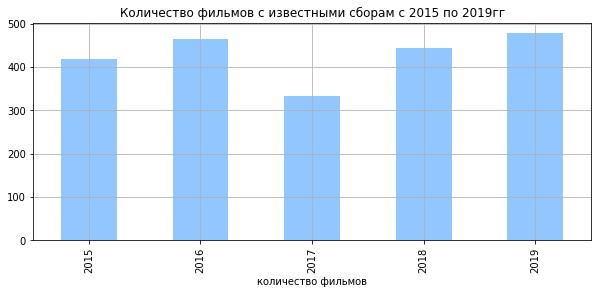

In [25]:
df_for_example = df.copy()
df.query('year >= 2015 and box_office > 0').groupby('year')['box_office'].count().plot(
    kind='bar', title='Количество фильмов с известными сборам с 2015 по 2019гг', xlabel='количество фильмов',
    figsize=(10, 4), grid=True)
plt.show()


- Изучите, как менялась динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?

In [26]:
df_group_box = df.query('year >= 2015').groupby('year')['box_office'].sum()
df_group_box = df_group_box / 1000000000

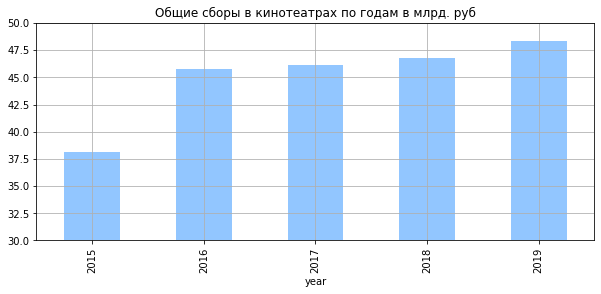

In [27]:
df_group_box.plot(kind='bar', title='Общие сборы в кинотеатрах по годам в млрд. руб', ylim=(30, 50),
                  grid=True, figsize=(10, 4))
plt.show()
del df_group_box

- С помощью сводной таблицы посчитайте среднюю и медианную сумму сборов для каждого года.

In [28]:
# поделил на млн, чтоб смотреть на миллионы. так удобнее.
df.query('year >= 2015 and box_office > 0').pivot_table(values='box_office',index='year', aggfunc=('mean', 'median', 'min', 'max'))/1000000

,max,mean,median,min
year,,,,
2015,1658.861425,91.253831,7.188504,0.000100
2016,2048.126108,98.512120,5.180851,0.000200
2017,2779.686144,138.500194,10.598124,0.024310
2018,2271.754005,105.454668,10.483426,0.046260
2019,3073.568691,101.039815,5.658057,0.004398


- Определите, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год? Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года? Если да, предположите, с чем это может быть связано.

In [29]:
df['age_restriction'] = df['age_restriction'].replace('«6+» - для детей старше 6 лет', '«06+» - для детей старше 6 лет')

In [30]:
df = df.query('year >= 2015 and box_office > 0')
df_group_all = df.pivot_table(
    index='age_restriction', values=['box_office'], aggfunc=['mean', 'median', 'sum', 'count']
)
df_group_all


,mean,median,sum,count
,box_office,box_office,box_office,box_office
age_restriction,,,,
«0+» - для любой зрительской аудитории,1.521056e+07,1.950019e+06,6.540543e+08,43
«06+» - для детей старше 6 лет,1.848360e+08,1.887846e+07,5.267825e+10,285
«12+» - для детей старше 12 лет,1.969292e+08,1.257782e+07,5.829106e+10,296
«16+» - для детей старше 16 лет,9.707133e+07,6.774523e+06,7.309471e+10,753
«18+» - запрещено для детей,5.318480e+07,6.615812e+06,4.047363e+10,761


In [31]:
df_group = df.pivot_table(
    index=['age_restriction', 'year'], values=['box_office'], aggfunc=['mean', 'median', 'sum', 'count'], margins=False
)

df_group.columns = ['mean', 'median', 'sum', 'count']
df_group


mean        median  \
age_restriction                        year                               
«0+» - для любой зрительской аудитории 2015  1.559892e+07  2.943319e+06   
                                       2016  4.701659e+06  2.930660e+05   
                                       2017  1.143286e+08  1.143286e+08   
                                       2018  2.055951e+06  2.055951e+06   
                                       2019  1.377963e+07  1.377963e+07   
«06+» - для детей старше 6 лет         2015  1.573160e+08  2.312598e+07   
                                       2016  1.772429e+08  4.475530e+06   
                                       2017  2.840657e+08  5.199210e+07   
                                       2018  1.602836e+08  2.128211e+07   
                                       2019  1.781139e+08  2.522082e+07   
«12+» - для детей старше 12 лет        2015  2.094695e+08  2.234363e+07   
                                       2016  1.692740e+08  1.200571e+07   
                                       2017  2.161780e+08  1.953190e+07   
                                       2018  2.227076e+08  1.260969e+07   
                                       2019  1.835672e+08  4.765560e+06   
«16+» - для детей старше 16 лет        2015  6.957870e+07  6.457303e+06   
                                       2016  9.387917e+07  5.524593e+06   
                                       2017  1.538165e+08  1.015010e+07   
                                       2018  1.055027e+08  1.009767e+07   
                                       2019  7.901012e+07  4.293650e+06   
«18+» - запрещено для детей            2015  4.286336e+07  5.034342e+06   
                                       2016  4.668420e+07  6.375092e+06   
                                       2017  6.775058e+07  8.561996e+06   
                                       2018  4.965551e+07  7.604029e+06   
                                       2019  5.755589e+07  5.712898e+06   

                                                      sum  count  
age_restriction                        year                       
«0+» - для любой зрительской аудитории 2015  3.275774e+08     21  
                                       2016  7.992821e+07     17  
                                       2017  2.286571e+08      2  
                                       2018  4.111901e+06      2  
                                       2019  1.377963e+07      1  
«06+» - для детей старше 6 лет         2015  7.865802e+09     50  
                                       2016  1.081181e+10     61  
                                       2017  1.107856e+10     39  
                                       2018  1.009787e+10     63  
                                       2019  1.282420e+10     72  
«12+» - для детей старше 12 лет        2015  1.361551e+10     65  
                                       2016  1.218773e+10     72  
                                       2017  7.350053e+09     34  
                                       2018  1.247162e+10     56  
                                       2019  1.266614e+10     69  
«16+» - для детей старше 16 лет        2015  1.106301e+10    159  
                                       2016  1.595946e+10    170  
                                       2017  1.784271e+10    116  
                                       2018  1.550890e+10    147  
                                       2019  1.272063e+10    161  
«18+» - запрещено для детей            2015  5.272193e+09    123  
                                       2016  6.769209e+09    145  
                                       2017  9.620582e+09    142  
                                       2018  8.739369e+09    176  
                                       2019  1.007228e+10    175

In [32]:
def set_columns(row):
    row['year'] = row.name[1]
    row['age_restraction'] = row.name[0]
    return row
    
df_group.apply(set_columns, axis=1)
df_group.reset_index(inplace=True)


In [34]:
fig = px.line(df_group, x='year', y='median', color='age_restriction', title='Медианое кол-во сборов по годам для разных категорий')
fig.show()
fig = px.line(df_group, x='year', y='count', color='age_restriction', title='Количество выпущенных фильмов по годам')
fig.show()
fig = px.line(df_group, x='year', y='mean', color='age_restriction', title='Средняя сумма сборов по годам для разных категорий')
fig.show()
del df_group, fig

In [35]:
fig = px.box(df.sort_values(by='age_restriction'), x='age_restriction', y='box_office', hover_name='title')
fig.show()
del fig

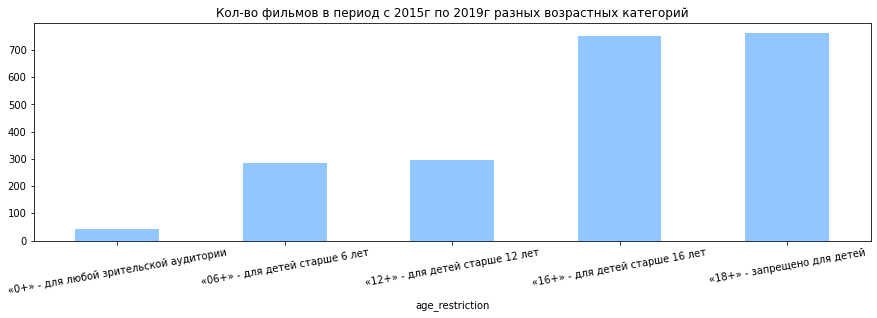

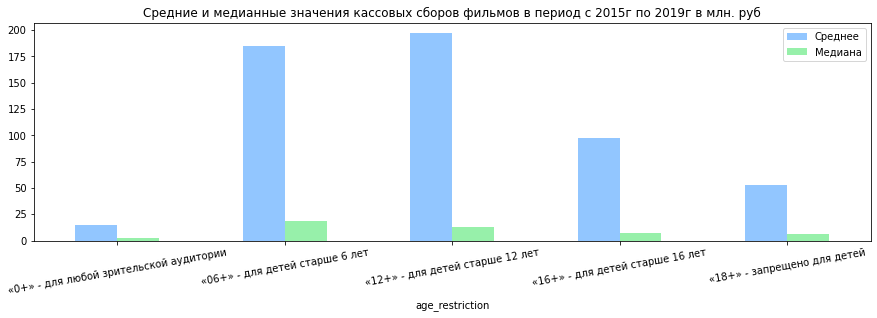

In [36]:
df_group_all.columns = ['Среднее','Медиана','Сумма','Кол-во']
df_group_all[['Среднее', 'Медиана']] = df_group_all[['Среднее', 'Медиана']] / 1e6
df_group_all.plot(kind='bar', y='Кол-во', rot=10, figsize=(15, 4),
                  title='Кол-во фильмов в период с 2015г по 2019г разных возрастных категорий',
                  legend=False)
plt.show()
df_group_all.plot(kind='bar', y=['Среднее', 'Медиана'], rot=10, figsize=(
    15, 4), title='Средние и медианные значения кассовых сборов фильмов в период с 2015г по 2019г в млн. руб')
plt.show()
del df_group_all


Больше всего фильмов выпускается 16+ и 18+.
Каких то явных тендеций не наблюдается, разве что можно отметить, что медианное значение по общему кол-ву сборов для фильмов с категорией 6+ выше чем для фильмов 16+ и 18+, такая картина наблюдается с 2017г.  
Есть заметный всплеск в 2017г. по медианным сборам для фильмов 0+, но доверять ему не стоит, т.к. фильмов 0+ выпускают очень мало в прокат, поэтому можно отнести такой всплеск к погрешности.  
Прослеживается очень большая разница между медианными сборами и сборами средними, преположительно это связано с тем что есть кассовые фильмы с большим кол-вом сборов, которые очень сильно правят средние. Если посмотреть на график с боксплотами, то можно увидеть эти фильмы-выбросы, но игнорировать их нельзя.

### Шаг 4. Исследуйте фильмы, которые получили государственную поддержку

На этом этапе нет конкретных инструкций и заданий — поищите интересные закономерности в данных. Посмотрите, сколько выделяют средств на поддержку кино. Проверьте, хорошо ли окупаются такие фильмы, какой у них рейтинг.

In [37]:
df = df.query('financing_total > 0')

In [38]:
df.head(5)

,title,puNumber,show_start_date,type,film_studio,production_country,producer,age_restriction,refundable_support,nonrefundable_support,...,financing_source,ratings,genres,box_office,part_of_state_budget,financing_total,is_rus,year,main_genre,correct_director
1853,Тайна Сухаревой башни. Чародей равновесия,114000115,2015-02-18 12:00:00+00:00,Анимационный,"ООО ""Студия ""Мастер-Фильм""",Россия,А.Герасимов,«06+» - для детей старше 6 лет,0.0,25000000.0,...,Министерство культуры,6.1,"мультфильм,фэнтези,история",15078858.6,0.482160,25000000.0,1,2015,мультфильм,С.Серегин
1869,А зори здесь тихие..._,111002915,2015-03-16 12:00:00+00:00,Художественный,"ООО ""Компания ""Реал-Дакота""",Россия,NaN,«12+» - для детей старше 12 лет,50000000.0,100000000.0,...,Фонд кино,8.5,"драма,военный,история",249166767.7,0.680000,150000000.0,1,2015,драма,Р.Давлетьяров
1902,Призрак_.,111001815,2015-03-02 12:00:00+00:00,Художественный,"ООО ""Водород 2011""",Россия,С.Сельянов,«06+» - для детей старше 6 лет,0.0,75000000.0,...,Фонд кино,7.0,"триллер,боевик,приключения",352804320.4,0.537436,75000000.0,1,2015,триллер,А.Войтинский
1911,Ведьма .,111002215,2015-03-05 12:00:00+00:00,Художественный,"ООО ""Кинокомпания ""Ракурс""",Россия,В.Сидоренко,«16+» - для детей старше 16 лет,0.0,34000000.0,...,Министерство культуры,7.4,"фэнтези,приключения,драма",51907.5,0.700000,34000000.0,1,2015,фэнтези,Д.Федоров
2057,Дуxless 2,111000415,2015-01-26 12:00:00+00:00,Художественный,"ООО ""Киностудия ""Слово"", ООО ""Арт Пикчерс Студия""",Россия,"П.Ануров, Ф.Бондарчук, Д.Рудовский",«16+» - для детей старше 16 лет,0.0,75000000.0,...,Фонд кино,6.6,драма,446163511.0,0.601220,75000000.0,1,2015,драма,Р.Прыгунов


In [39]:
df['production_country'].value_counts()

Россия                                        273
Россия, Италия                                  2
Россия, Германия                                2
Россия-Украина                                  1
Россия, Украина, Польша                         1
Россия, Германия, Великобритания                1
Россия, Армения                                 1
Россия-Словакия-Чехия                           1
Россия, Латвия, Чешская Республика              1
Россия, Германия, Казахстан, Польша, Китай      1
Россия, Сербия                                  1
Россия-Китай                                    1
Name: production_country, dtype: int64

In [40]:
273 / len(df)

0.9545454545454546

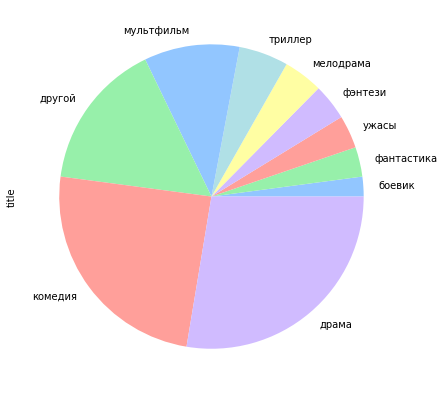

In [41]:
df.groupby('main_genre')['title'].count().sort_values().plot(kind='pie', figsize=(7,7))
plt.show()

In [42]:
df['payback'] = df['box_office'] - df['budget']
df['payback_bool'] = df['payback'].apply(lambda row: 'Окупился' if row > 0 else 'Не окупился')

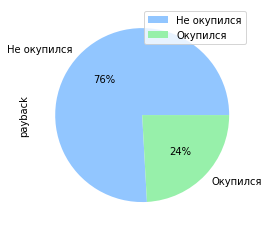

,count,sum
,payback,payback
payback_bool,,
Не окупился,217,-20.130427
Окупился,69,19.485469


In [43]:
df_pivot = df.pivot_table(values='payback', index='payback_bool', aggfunc=['count', 'sum'])
df_pivot.plot(kind='pie', subplots=True, y='count', autopct='%1.0f%%', legend=True, label='')
plt.show()
df_pivot['sum'] /= 1e9 # В млрд рублей
display(df_pivot) 
del df_pivot

In [44]:
pd.options.display.float_format ='{:,.1f}'.format

In [45]:
df.pivot_table(values=['nonrefundable_support', 'refundable_support', 'budget' , 'box_office', 'payback'], 
               index='correct_director', 
               aggfunc=['sum', 'count']).sort_values(by=('sum', 'nonrefundable_support'), ascending=False).head(5)

sum                                      \
                      box_office        budget nonrefundable_support   
correct_director                                                       
Н.Хомерики         618,142,950.2 983,501,686.8         540,000,000.0   
А.Кравчук          717,703,185.5 980,000,000.0         400,000,000.0   
А.Мегердичев     2,779,686,144.0 590,192,191.0         400,000,000.0   
Н.Лебедев        1,402,255,390.0 635,283,867.0         392,104,482.0   
А.Мизгирев         364,285,139.6 684,200,536.0         300,000,000.0   

                                                         count         \
                         payback refundable_support box_office budget   
correct_director                                                        
Н.Хомерики        -365,358,736.6      120,000,000.0          3      3   
А.Кравчук         -262,296,814.5      100,000,000.0          1      1   
А.Мегердичев     2,189,493,953.0                0.0          1      1   
Н.Лебедев          766,971,523.0       50,000,000.0          1      1   
А.Мизгирев        -319,915,396.4      150,000,000.0          1      1   

                                                                   
                 nonrefundable_support payback refundable_support  
correct_director                                                   
Н.Хомерики                           3       3                  3  
А.Кравчук                            1       1                  1  
А.Мегердичев                         1       1                  1  
Н.Лебедев                            1       1                  1  
А.Мизгирев                           1       1                  1

no comment

In [46]:
df.query('correct_director == "Р.Давлетьяров"')

,title,puNumber,show_start_date,type,film_studio,production_country,producer,age_restriction,refundable_support,nonrefundable_support,...,genres,box_office,part_of_state_budget,financing_total,is_rus,year,main_genre,correct_director,payback,payback_bool
1869,А зори здесь тихие..._,111002915,2015-03-16 12:00:00+00:00,Художественный,"ООО ""Компания ""Реал-Дакота""",Россия,NaN,«12+» - для детей старше 12 лет,"50,000,000.0","100,000,000.0",...,"драма,военный,история","249,166,767.7",0.7,"150,000,000.0",1,2015,драма,Р.Давлетьяров,"28,578,373.7",Окупился
2481,Однажды._,111004215,2015-04-15 12:00:00+00:00,Художественный,"ООО ""Компания ""РЕАЛ-ДАКОТА"", НП ""Интерфест""",Россия,"Р.Давлетьяров, А.Котелевский",«16+» - для детей старше 16 лет,0.0,"97,000,000.0",...,"драма,криминал,детектив","12,748,398.3",0.6,"97,000,000.0",1,2015,драма,Р.Давлетьяров,"-143,612,267.7",Не окупился
2722,Чистое искусство.,111008715,2015-05-05 12:00:00+00:00,Художественный,"ООО ""КОМПАНИЯ ""РЕАЛ-ДАКОТА""",Россия,Р.Давлетьяров,«16+» - для детей старше 16 лет,"15,000,000.0","60,000,000.0",...,"триллер,детектив","6,457,303.0",0.7,"75,000,000.0",1,2015,триллер,Р.Давлетьяров,"-105,278,860.0",Не окупился
6919,Донбасс. Окраина,111007919,2019-06-12 12:00:00+00:00,Художественный,"АНО ""Интерфест"", ООО ""Пропеллер Продакшн""",Россия,"Р.Давлетьяров, Г.Поземельный",«12+» - для детей старше 12 лет,0.0,"30,000,000.0",...,"драма,военный,триллер","10,933,431.9",0.3,"30,000,000.0",1,2019,драма,Р.Давлетьяров,"-94,788,092.1",Не окупился


In [47]:
df_pivot = df.pivot_table(values=['nonrefundable_support', 'refundable_support', 'budget' , 'box_office', 'payback', 'financing_total'], 
               index='correct_director', 
               aggfunc=['sum', 'count']).sort_values(by=('count', 'nonrefundable_support'), ascending=False)
df_pivot.drop(columns=[('count', 'budget'),
            ('count', 'nonrefundable_support'),
            ('count', 'payback'),
            ('count', 'financing_total'),
            ('count', 'refundable_support')], inplace=True)
df_pivot.columns = ['box_office', 'budget','financing_total','nonrefundable_support','payback','refundable_support','count_films']
df_pivot.query('count_films >= 2').sort_values(by='payback', ascending=False)

,box_office,budget,financing_total,nonrefundable_support,payback,refundable_support,count_films
correct_director,,,,,,,
К.Шипенко,"3,826,248,467.8","653,733,957.0","285,000,000.0","260,000,000.0","3,172,514,510.8","25,000,000.0",2
Д.Дьяченко,"2,404,898,634.1","780,695,312.0","351,000,000.0","180,000,000.0","1,624,203,322.1","171,000,000.0",4
Д.Шмидт,"1,412,475,637.0","714,163,376.0","215,000,000.0","115,000,000.0","698,312,261.0","100,000,000.0",3
Д.Киселев,"1,399,783,312.0","702,823,899.0","350,000,000.0","225,000,000.0","696,959,413.0","125,000,000.0",2
Т.Бекмамбетов,"1,009,908,513.0","394,871,057.0","250,000,000.0","175,000,000.0","615,037,456.0","75,000,000.0",2
Р.Прыгунов,"854,810,176.7","364,787,583.0","215,000,000.0","215,000,000.0","490,022,593.7",0.0,2
Р.Гигинеишвили,"405,825,165.0","160,273,277.0","90,000,000.0","80,000,000.0","245,551,888.0","10,000,000.0",2
К.Дружинин,"459,377,899.8","225,389,238.0","90,000,000.0","90,000,000.0","233,988,661.8",0.0,2
Р.Каримов,"275,176,282.0","81,252,509.0","53,345,000.0","53,345,000.0","193,923,773.0",0.0,2


In [48]:
# Интересно посмотреть было самые косячные фильмы и самые не косячные
df.sort_values(by='payback')[['title','correct_director','payback','financing_total','budget','nonrefundable_support', 'type', 'main_genre']]

,title,correct_director,payback,financing_total,budget,nonrefundable_support,type,main_genre
7111,Тайна Печати Дракона,О.Степченко,"-1,971,477,243.4","270,000,000.0","2,305,074,303.0","90,000,000.0",Художественный,другой
7168,Грех,А.Михалков,"-725,698,762.3","60,000,000.0","779,941,965.0","60,000,000.0",Художественный,драма
5434,Матильда,А.Учитель,"-521,130,409.0","300,000,000.0","1,032,905,957.0","190,000,000.0",Художественный,фэнтези
2141,Территория,А.Мельник,"-427,421,682.6","60,000,000.0","500,000,000.0","30,000,000.0",Художественный,другой
6884,Девятая,Н.Хомерики,"-397,827,778.6","300,000,000.0","453,704,666.0","300,000,000.0",Художественный,другой
...,...,...,...,...,...,...,...,...
2919,Экипаж .,Н.Лебедев,"766,971,523.0","442,104,482.0","635,283,867.0","392,104,482.0",Художественный,драма
5502,Последний богатырь,Д.Дьяченко,"1,302,560,113.0","100,000,000.0","352,477,575.0","50,000,000.0",Художественный,комедия
6546,Т-34,А.Сидоров,"1,707,969,287.5","180,000,000.0","563,784,717.0","120,000,000.0",Художественный,драма
5650,Движение вверх,А.Мегердичев,"2,189,493,953.0","400,000,000.0","590,192,191.0","400,000,000.0",Художественный,другой


In [49]:
df.query('correct_director == "Р.Давлетьяров"')

,title,puNumber,show_start_date,type,film_studio,production_country,producer,age_restriction,refundable_support,nonrefundable_support,...,genres,box_office,part_of_state_budget,financing_total,is_rus,year,main_genre,correct_director,payback,payback_bool
1869,А зори здесь тихие..._,111002915,2015-03-16 12:00:00+00:00,Художественный,"ООО ""Компания ""Реал-Дакота""",Россия,NaN,«12+» - для детей старше 12 лет,"50,000,000.0","100,000,000.0",...,"драма,военный,история","249,166,767.7",0.7,"150,000,000.0",1,2015,драма,Р.Давлетьяров,"28,578,373.7",Окупился
2481,Однажды._,111004215,2015-04-15 12:00:00+00:00,Художественный,"ООО ""Компания ""РЕАЛ-ДАКОТА"", НП ""Интерфест""",Россия,"Р.Давлетьяров, А.Котелевский",«16+» - для детей старше 16 лет,0.0,"97,000,000.0",...,"драма,криминал,детектив","12,748,398.3",0.6,"97,000,000.0",1,2015,драма,Р.Давлетьяров,"-143,612,267.7",Не окупился
2722,Чистое искусство.,111008715,2015-05-05 12:00:00+00:00,Художественный,"ООО ""КОМПАНИЯ ""РЕАЛ-ДАКОТА""",Россия,Р.Давлетьяров,«16+» - для детей старше 16 лет,"15,000,000.0","60,000,000.0",...,"триллер,детектив","6,457,303.0",0.7,"75,000,000.0",1,2015,триллер,Р.Давлетьяров,"-105,278,860.0",Не окупился
6919,Донбасс. Окраина,111007919,2019-06-12 12:00:00+00:00,Художественный,"АНО ""Интерфест"", ООО ""Пропеллер Продакшн""",Россия,"Р.Давлетьяров, Г.Поземельный",«12+» - для детей старше 12 лет,0.0,"30,000,000.0",...,"драма,военный,триллер","10,933,431.9",0.3,"30,000,000.0",1,2019,драма,Р.Давлетьяров,"-94,788,092.1",Не окупился


In [50]:
df.pivot_table(values=['nonrefundable_support', 'refundable_support'], index='financing_source', aggfunc=['mean', 'sum'])

mean                     \
                                 nonrefundable_support refundable_support   
financing_source                                                            
Министерство культуры                     30,038,365.7                0.0   
Министерство культуры, Фонд кино          36,968,280.8       16,972,222.2   
Фонд кино                                 71,815,511.6       25,018,656.7   

                                                   sum                     
                                 nonrefundable_support refundable_support  
financing_source                                                           
Министерство культуры                  4,025,141,000.0                0.0  
Министерство культуры, Фонд кино         665,429,055.0      305,500,000.0  
Фонд кино                              9,623,278,548.0    3,352,500,000.0

In [51]:
df.groupby('main_genre')['financing_total'].sum().sort_values(ascending=False)

main_genre
драма        4,843,904,333.0
другой       4,082,963,985.0
комедия      2,952,435,000.0
мультфильм   2,380,000,000.0
фэнтези      1,032,900,000.0
фантастика     881,000,000.0
триллер        769,645,285.0
ужасы          355,000,000.0
мелодрама      340,000,000.0
боевик         334,000,000.0
Name: financing_total, dtype: float64

In [52]:
df.query(
    'main_genre == "другой"').sort_values(
        by='financing_total', ascending=False)[['title','main_genre','genres','financing_total']].head(15)

,title,main_genre,genres,financing_total
7461,Союз спасения,другой,"история,биография,драма","500,000,000.0"
5650,Движение вверх,другой,"спорт,драма","400,000,000.0"
5566,Легенда о Коловрате,другой,"история,боевик,фэнтези","350,000,000.0"
6884,Девятая,другой,"детектив,триллер,криминал","300,000,000.0"
7111,Тайна Печати Дракона,другой,"приключения,фэнтези","270,000,000.0"
3254,Время первых (2017),другой,"приключения,триллер,биография","250,000,000.0"
3626,БОЛЬШОЙ,другой,"криминал,комедия,боевик","210,000,000.0"
3609,Ёлки 5,другой,"семейный,комедия","150,000,000.0"
3163,Герой (2015),другой,"мюзикл,боевик,драма","140,000,000.0"
6696,Тобол,другой,"история,драма","130,000,000.0"


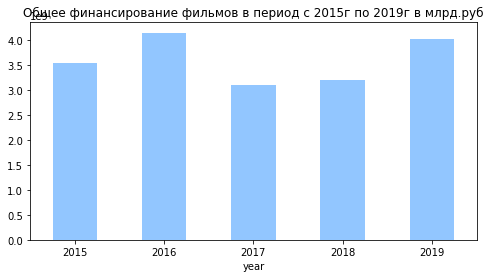

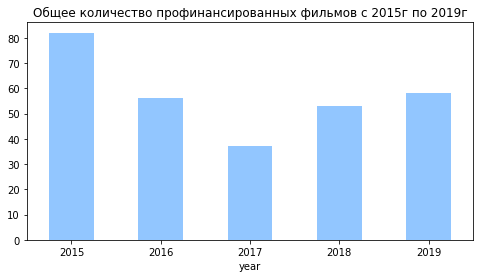

In [53]:
df.groupby('year')['financing_total'].sum().plot(kind='bar', rot=0, 
                                                 title='Общее финансирование фильмов в период с 2015г по 2019г в млрд.руб',
                                                 figsize=(8,4))
plt.show()
df.groupby('year')['financing_total'].count().plot(kind='bar', rot=0, 
                                                 title='Общее количество профинансированных фильмов с 2015г по 2019г',
                                                 figsize=(8,4))
plt.show()

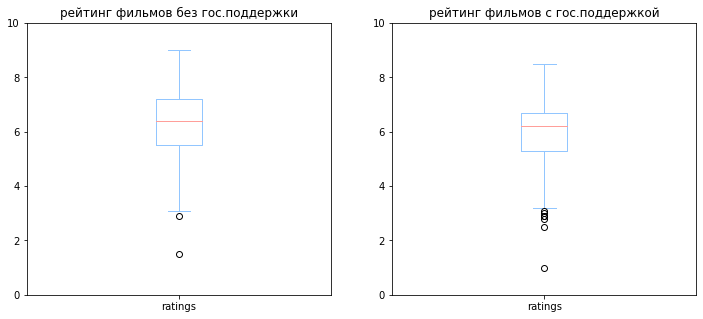

In [54]:
df_for_example = df_for_example.query('financing_source == "Без госсподдержки" and year >= 2015')
df_for_example = df_for_example[df_for_example['production_country'].isin(['Россия'])]
df_for_example = df_for_example[df_for_example['ratings'].notnull()]
plt.subplot(1,2,1)
df_for_example['ratings'].plot(kind='box', title='рейтинг фильмов без гос.поддержки', ylim=(0,10))
plt.subplot(1,2,2)
df['ratings'].plot(kind='box', figsize=(12,5), title='рейтинг фильмов с гос.поддержкой', ylim=(0,10))
plt.show()

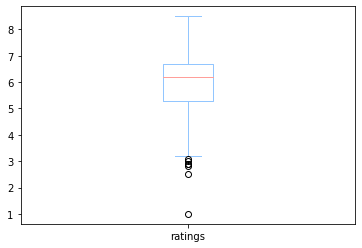

In [55]:
df['ratings'].plot(kind='box')
plt.show()

In [56]:
display(df.pivot_table(values='ratings', index='age_restriction', aggfunc=[
        'mean', 'count']).sort_values(by=('mean','ratings'), ascending=False))
display(df_for_example.pivot_table(values='ratings', index='age_restriction',
        aggfunc=['mean', 'count']).sort_values(by=('mean','ratings'), ascending=False))


,mean,count
,ratings,ratings
age_restriction,,
«18+» - запрещено для детей,6.2,24
«0+» - для любой зрительской аудитории,6.2,2
«12+» - для детей старше 12 лет,6.1,88
«06+» - для детей старше 6 лет,5.9,61
«16+» - для детей старше 16 лет,5.9,109


,mean,count
,ratings,ratings
age_restriction,,
«6+» - для детей старше 6 лет,6.5,48
«12+» - для детей старше 12 лет,6.5,195
«16+» - для детей старше 16 лет,6.2,171
«18+» - запрещено для детей,5.9,67
«0+» - для любой зрительской аудитории,5.5,42


In [57]:
df.groupby('age_restriction')['payback'].sum()

age_restriction
«0+» - для любой зрительской аудитории     -187,646,659.0
«06+» - для детей старше 6 лет              187,873,679.4
«12+» - для детей старше 12 лет           4,522,699,441.8
«16+» - для детей старше 16 лет          -3,678,261,605.6
«18+» - запрещено для детей              -1,489,622,783.1
Name: payback, dtype: float64

In [58]:
display(df.groupby('age_restriction')['ratings'].mean().sort_values(ascending=False))

age_restriction
«18+» - запрещено для детей              6.2
«0+» - для любой зрительской аудитории   6.2
«12+» - для детей старше 12 лет          6.1
«06+» - для детей старше 6 лет           5.9
«16+» - для детей старше 16 лет          5.9
Name: ratings, dtype: float64

### Шаг 5. Напишите общий вывод

  Фильмы получившие поддержку: 95% единолично выпускаются Россией, и только 5% совместно с другими странами.  
Самые финансируемые жанры: драма -> комедия -> мультфильмы, остальные жанры примерно поровну  
Окупается всего 1/4 всех фильмов.  Однако суммы выделенные на окупившиеся и не окупившиеся фильмы примерно одинаковы.
Общая сумма невозвратных средств - ~14млрд. рублей из них 4млрд.рублей из Министерства культуры, основная же часть финансируется фондом Кино. При этом Министерство Культуры всегда выделяет невозвратные средства, Фонд Кино может выделить средства "в долг".  
По графикам видно, что средняя оценка фильмов с гос.поддержкой ниже фильмов без гос.поддержки.  
Невозвратные средства, обычно предназначаются для фильмов либо  документальных, патриотических, либо несущих культурно-просветительскую функцию, в нашем случае мы видим, что к сожалению большинство финансируемых фильмов таковыми не являются. Они либо пропагандисткие, либо развлекательные... можем сделать предположение, что фильмы развлекательные имеют коррупционные корни поддержки.  
Сравнивая рейтинги фильмов с гос.поддержкой и без, можно также сделать вывод что Фонд Кино совместно с Министерство культуры либо очень не умело выбирают киноленты для финансирования, либо ...  
Резюмирую:
- Количество выпускаемых фильмов с 2015 по 2019 не сказать что имеет какую то четкую тенденцию по изменению кол-ва, вроде фильмов стало больше, а вроде и в 2017г их было меньше всего.
- Похожая ситуация и с выручкой: явной тенденции не наблюдается.
- На основании анализа окупаемости фильмов по возрастным категориям, выявляется тенденция успешности в прокате фильмов возрастной категории 12+ и 6+ 
- Количество фильмов с гос.поддержкой упало по сравнению с 2015г, возможно связано с теми что фильмы 2015 были профинансированы еще в 2014г, и после очередного обвала рубля(в 2014г) финансирование кинематографа государством было сокращено. Далее показатель по-тихоньку приходил в норму.
- Самый успешный(+3млрд.руб) в прокате фильм с гос.поддержкой: "Холоп"
- Самый провальный(-2млрд.руб) в прокате фильм с гос.поддержкой: "Тайна Печати Дракона"
- Самую большую невозвратную гос.поддержку(400млн) получили фильмы: "Движение вверх", "Союз спасени", "Экипаж"
- По результатам анализа выборки картин режиссеров получивших гос.поддержку более чем на 2фильма за 5лет: 
  - Н.Хомерики получил максимальный объем гос.поддержки(3картины, 660млн)
  - Максимальное кол-во картин выпущенных режиссером за 5лет и получившим гос.поддержку: 4фильма(С.Андреасян, Д.Дьяченко, Р.Давлетьяров)
  - Самые провальными оказались фильмы Р.Давлетьярова(-365млн.руб) и коммерчески успешными фильмы Д.Дьяченко(+1,6млрд.руб)
